# **MNIST Convolutional Neural Network (CNN)**

In this notebook we want you to take a step further and implement a convolutional neural network to beat the performance of your mlp classifier. In addition, we will show you how to track the training process with [tensorboard](https://www.tensorflow.org/tensorboard). Finally, you visualize the discriminative power of your CNN with [t-SNE](https://lvdmaaten.github.io/tsne/).

<br>

**Task:**

- Please solve all the tasks with code.
- You are free to use any python package you like, however, the imports should be enough to solve all the tasks.
- Questions (marked with QUESTION tag) requires you to write a short and concise text.

**Note:**
- Keep in mind that there is not only one solution for each task.
- If you need any help use the [Tensorflow Documentation](https://www.tensorflow.org/) or the [Keras Documentation](https://keras.io)

## Prerequisites

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.8.0
[]


In [2]:
# Import MNIST data

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

RECAP: Repeat the preprocessing steps from the last exercise!

Note: You also need to reshape the images as the convolutional layers expect a color channel (Width, Height, Channel)!

In [3]:
# Normalize the images and add a color channel
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

mms = MinMaxScaler()
mms.fit(x_train.reshape(len(x_train), -1))

x_train = mms.transform(x_train.reshape(len(x_train), -1)).reshape(*x_train.shape, 1)
x_test = mms.transform(x_test.reshape(len(x_test), -1)).reshape(*x_test.shape, 1)

# One-hot encode labels
ohe = OneHotEncoder(sparse=False)

y_train = ohe.fit_transform(y_train.reshape(-1, 1))
y_test = ohe.transform(y_test.reshape(-1, 1))



Setting up tensorboard.

In [4]:
# Loading the tensorboard extension
%load_ext tensorboard

In [5]:
# Setting up tensorboard
tensorboard = TensorBoard(
    log_dir='./logs',
    histogram_freq=1
)
keras_callbacks = [
    tensorboard
]

## Learning a CNN


Define an arbitrary CNN!

In [6]:
cnn = tf.keras.models.Sequential([
    tf.keras.layers.Convolution2D(filters=64, kernel_size=(3,3), input_shape=x_train.shape[1:], activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Convolution2D(filters=64, kernel_size=(3,3), batch_size=32, activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Convolution2D(filters=64, kernel_size=(3,3), batch_size=32, activation="relu"),
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(10, activation="softmax"),
])

Define hyperparameters, cost function (loss) and optimizer!

In [7]:
learning_rate = 0.001
batch_size = 64  # standard mini batch sizes are 32 or 64 and should generally be 2^x to leverage gpu processing
epochs = 5
validation_split = 0.2

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)  # goto
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy()]

Compile the model and train it on the training set!

Note: Add the `callbacks` argument to the `fit()` method to track your training in tensorboard!

In [8]:
cnn.compile(optimizer=optimizer, loss=loss, metrics=metrics)
cnn.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=keras_callbacks)

Epoch 1/5
750/750 [==============================] - 18s 23ms/step - loss: 0.2561 - categorical_accuracy: 0.9198 - val_loss: 0.0781 - val_categorical_accuracy: 0.9774
Epoch 2/5
750/750 [==============================] - 18s 23ms/step - loss: 0.0660 - categorical_accuracy: 0.9791 - val_loss: 0.0642 - val_categorical_accuracy: 0.9808
Epoch 3/5
750/750 [==============================] - 17s 23ms/step - loss: 0.0464 - categorical_accuracy: 0.9854 - val_loss: 0.0628 - val_categorical_accuracy: 0.9808
Epoch 4/5
750/750 [==============================] - 18s 24ms/step - loss: 0.0364 - categorical_accuracy: 0.9886 - val_loss: 0.0517 - val_categorical_accuracy: 0.9854
Epoch 5/5
750/750 [==============================] - 18s 24ms/step - loss: 0.0279 - categorical_accuracy: 0.9906 - val_loss: 0.0479 - val_categorical_accuracy: 0.9869


Start tensorboard and have a look at the training process!

Note: You can also run tensorboard before the training for live-tracking.

In [9]:
%tensorboard --logdir logs

Evaluate the performance of your classifier! It should achieve high accuracy (> 98%) on the test set!

You might adjust the model architecture and/or the hyperparameters if you don't make it above 98% accuracy.

In [10]:
prediction_loss, prediction_accuracy = cnn.evaluate(x_test, y_test, batch_size=batch_size)

print(f"Loss: {prediction_loss}, Accuracy: {prediction_accuracy}")

157/157 [==============================] - 1s 6ms/step - loss: 0.0418 - categorical_accuracy: 0.9874
Loss: 0.041798897087574005, Accuracy: 0.9873999953269958


Use the test set and take the outputs of the penultimate fully connected layer (not the logits!) and visualize it with t-SNE!

<br>

Hint: Have a look in the [Keras FAQ Documentation](https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction) to find out how to get intermediate outputs of any layer.

In [11]:
# Make predictions for the test set and convert them back to categorical
cat_y_pred = tf.argmax(cnn.predict(x_test), axis=1)


In [12]:
# Build a model for the outputs of the penultimate fully connected layer
intermediate_layer_model = tf.keras.Model(inputs=cnn.inputs, outputs=[layer.output for layer in cnn.layers if str.startswith(layer.name, "dense")][-2])
intermediate_output = intermediate_layer_model(x_test)

In [13]:
# Instantiate and fit t-SNE
tsne = TSNE(2, verbose=1)
tsne_proj = tsne.fit_transform(intermediate_output.numpy())

c:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Sebastian\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 1.979s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 2.509518
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.461899
[t-SNE] KL divergence after 1000 iterations: 1.594107


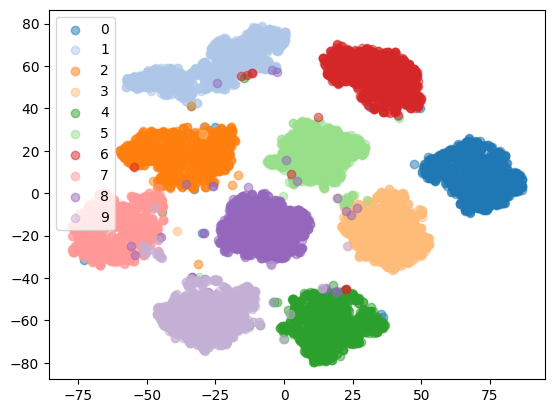

In [14]:
# Plot t-SNE projections
cmap = cm.get_cmap('tab20')
n_classes = 10
fig, ax = plt.subplots()
for label in range(n_classes):
    idx = cat_y_pred == label
    ax.scatter(tsne_proj[idx, 0], tsne_proj[idx, 1], c=np.array(cmap(label)).reshape(1, 4), label=label, alpha=0.5)
ax.legend()
plt.show()